**Вместо предисловия, тройка ссылок, которые точно стоит почитать**

Немножко теоретической теории, вроде разжёвано неплохо.

https://habr.com/ru/companies/otus/articles/732080/?ysclid=mfu9a2anz3256230087

Базовая база этой работы.

https://habr.com/ru/companies/mvideo/articles/769190/?ysclid=mfu9a7bqnl351830679

Мне понравился раздел с оценкой модели. Да и вообще статья звучит хорошо.

https://timeweb.cloud/tutorials/python/prognozirovanie-vremennyh-ryadov-python-3

---



Установка необходимых пакетов.

In [1]:
!pip install pandas numpy matplotlib statsmodels

Импорты для работы с таблицей, отрисовки и тестирования на стационарность.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

Чтение данных

In [3]:
data = pd.read_csv('analytic-v.csv')
data

,time,people_amount
0,1.757916e+09,1
1,1.757916e+09,1
2,1.757916e+09,1
3,1.757916e+09,1
4,1.757916e+09,1
...,...,...
8544,1.757959e+09,1
8545,1.757959e+09,1
8546,1.757959e+09,1
8547,1.757959e+09,1


Посмотреть на сырые данные.

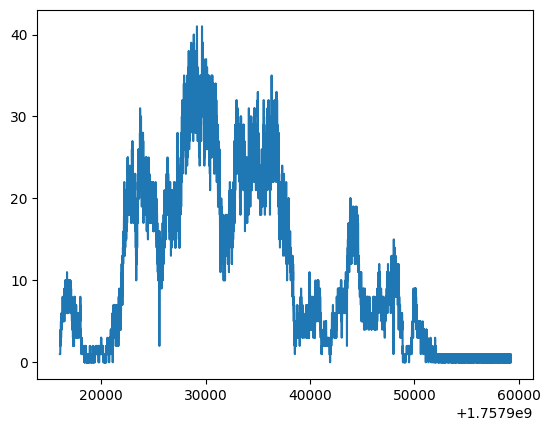

In [4]:
plt.plot(data['time'], data['people_amount'])
plt.show()

Преобразование формата данных.

In [5]:
import datetime
data['time'] = data['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data

,time,people_amount
0,2025-09-15 06:00:35.713500,1
1,2025-09-15 06:00:40.750300,1
2,2025-09-15 06:00:45.766100,1
3,2025-09-15 06:00:50.792100,1
4,2025-09-15 06:00:55.818600,1
...,...,...
8544,2025-09-15 18:00:14.693200,1
8545,2025-09-15 18:00:19.735300,1
8546,2025-09-15 18:00:24.764000,1
8547,2025-09-15 18:00:29.789000,1


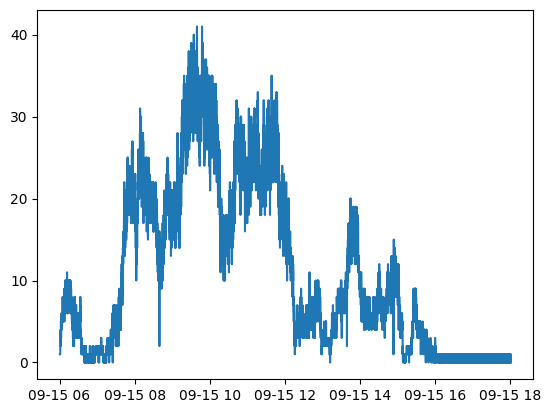

In [6]:
plt.plot(data['time'], data['people_amount'])
plt.show()

Проверка на стационарность.

In [7]:
result = adfuller(data['people_amount'])
print('Значение: %f' % result[0])
print('Вероятность: %f' % result[1])
print('Пороговые значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Значение: -1.751100
Вероятность: 0.404995
Пороговые значения:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Уменьшить частоту замеров, усредняя по пять минут.

In [8]:
data = data.groupby(pd.Grouper(key='time', axis=0, freq='5min')).mean().reset_index()
data

,time,people_amount
0,2025-09-15 06:00:00,4.132075
1,2025-09-15 06:05:00,6.883333
2,2025-09-15 06:10:00,8.237288
3,2025-09-15 06:15:00,7.900000
4,2025-09-15 06:20:00,4.474576
...,...,...
140,2025-09-15 17:40:00,0.433333
141,2025-09-15 17:45:00,0.383333
142,2025-09-15 17:50:00,0.525424
143,2025-09-15 17:55:00,0.400000


Вычесть тренд и получить стационарный ряд.

In [9]:
data['without_trend'] = data['people_amount'] - data['people_amount'].rolling(window=6).mean()
data['stat'] = data['without_trend'].diff(periods=1).dropna()

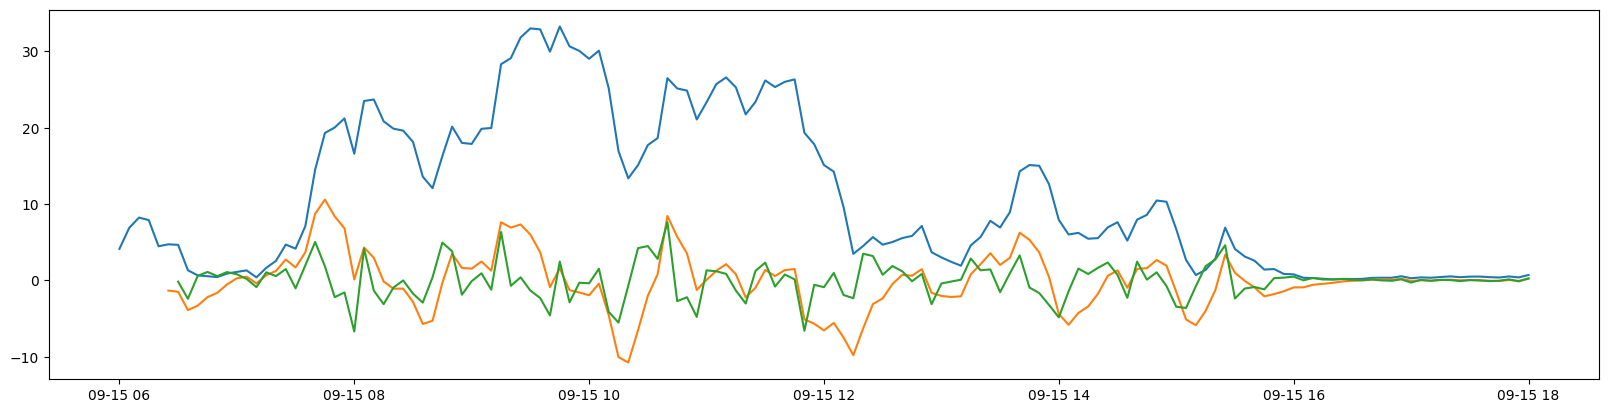

In [10]:
plt.figure().set_figwidth(20)
plt.plot(data['time'], data['people_amount'])
plt.plot(data['time'], data['without_trend'])
plt.plot(data['time'], data['stat'])
plt.show()

Посмотреть на автокорреляцию и частичную автокорреляцию (вообще, нужно для определения параметров ARIMA, но пока вдаваться не будем; впрочем, знание способа выбора парамтров будет плюсом).

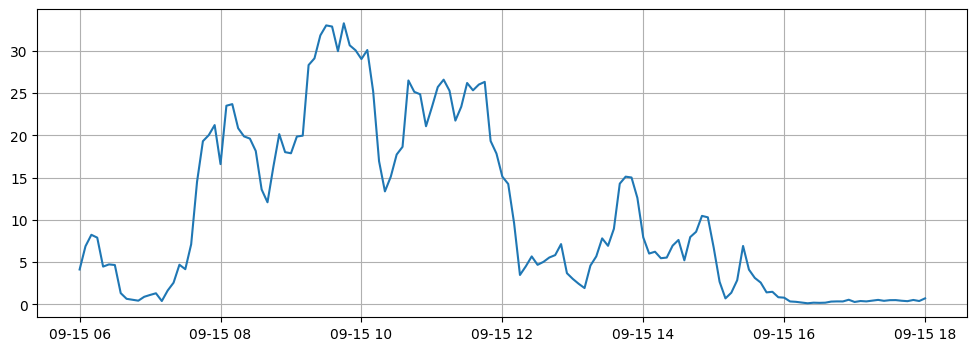

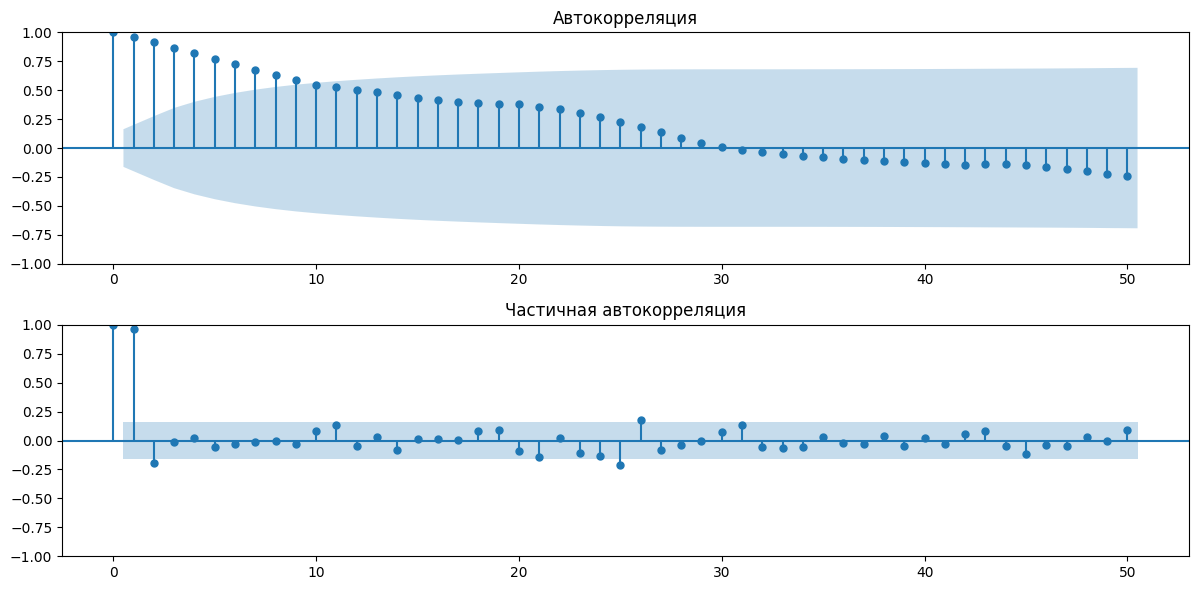

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 4))
plt.plot(data['time'], data['people_amount'])
plt.grid(True)
plt.show()

# Рассчитываем автокорреляцию и частичную автокорреляцию
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['people_amount'], lags=50, ax=plt.gca())
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(data['people_amount'], lags=50, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Собственно, обучение модели для прогнозирования. ARIMA - самая базированная из тех, что реально используются (если верить интернету), так что посмотреть на неё стоит.

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Обучение модели ARIMA
model = ARIMA(data['people_amount'], order=(1, 1, 1))
model_fit = model.fit()

# Вывод статистики модели
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          people_amount   No. Observations:                  145
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -333.735
Date:                Mon, 22 Sep 2025   AIC                            673.469
Time:                        00:15:28   BIC                            682.379
Sample:                             0   HQIC                           677.090
                                - 145                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1747      0.429      0.407      0.684      -0.667       1.016
ma.L1          0.0452      0.427      0.106      0.916      -0.792       0.882
sigma2         6.0314      0.508     11.880      0.0

Диаграммы для оценки модели.

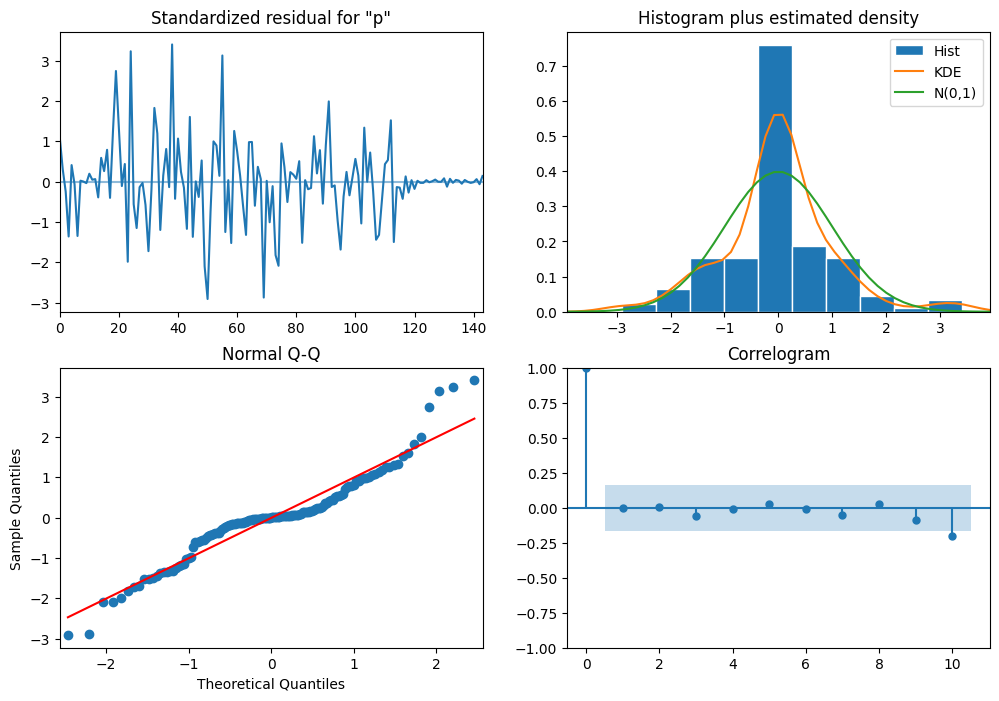

In [13]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

Сравнение предсказанных данных и реальных.

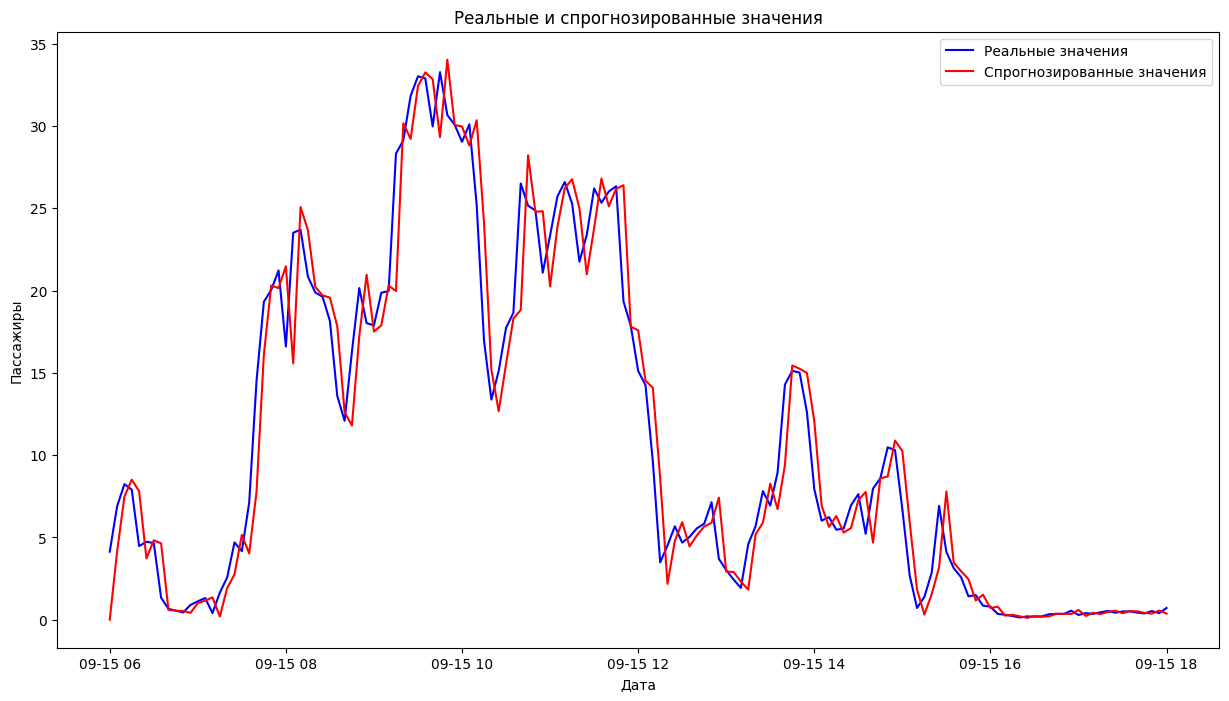

In [14]:
st_pred = model_fit.get_prediction()
forecast_values = st_pred.predicted_mean
plt.figure(figsize=(15,8))
plt.plot(data['time'], data['people_amount'], label='Реальные значения', color='blue')
plt.plot(data['time'], forecast_values, label='Спрогнозированные значения', color='red')
plt.title('Реальные и cпрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()

plt.show()

Собственно, задачи на ЛР1:

* Изучить приведённый код.
* Прочесть литературу на тему (хотя бы те три статьи из шапки).
* Выполнить существующий код на данных для своего варианта.
* Оптимизировать код согласно вашим представлениям о прекрасном (исправить допущенные в нём оплошности и видоизменить до максимальной уникализации).

---

Буду спрашивать:
* Всё, что упоминается в этой странице. "Что такое тренд", "Зачем получать стационарный ряд", "Как добавить сетку на график", "Почему из 09 вычитается 15" и тому подобные вопросы.
* Некоторую базовую теорию из литературы. Стационарность, тренд, из чего состоит ARIMA и зачем вообще этим всем заниматься.
* Изменённые параметры. Почему изменили именно их и чем обусловлен выбор значения. Если это не будет подробно описано в самой работе.
* По настроению будут вопросы по python. Тут непредсказуемо и зависит от целого ряда совпадений.
